   # Validation of static linear solver
   
Studies consider a flat/cambered plate models. 
   
All cases are defined as follows:
   - A nonlinear (geometrically-exact) static solution is obtained for an arbitrary geometry/flow condition;
   - A linearisation is performed about this configuration;
   
   
   #### Important:
   This version of the linear solver is based on a linearisation of the state equations only. Once the circulation $\Delta\Gamma$ is obtained, this is added to the circulation at the reference conditions, $\Gamma_0$. The total circulation, $\Gamma=\Gamma_0+\Delta\Gamma$ is finally used to obtain the induced velocity field. The total velocity field, $V$, is obtained upon summation with the free stream velocity, $U_\infty$ and gust disturbances/aerofoil motion ($\nu,\zeta'$). Finally, the total velocity $V$ is used to compute the the steady forces through Joukovski theorem.

In [45]:
import os,sys
sys.path.append('..')

import numpy  as np
import scipy.optimize as scopt
import matplotlib.pyplot as plt

import uvlm2d_sta as uvlm
import lin_uvlm2d_sta as linuvlm

import geo
import pp_uvlm2d as pp

## Flat plate: nonlinear vs. linearisation around 0 deg

In this test a model of a flat plate at zero angle of attack is created and linearised. A rotation is imposed on the linear model and the force coefficients are computed. The results are compared against the nonlinear solution for different paneling/angles of attack.

#### Note: 
In order to rotate the aerofoil, a set of nodal displacements $\Delta\zeta$ is applied. Importantly, the rotation is exact, i.e. both horizontal and vertical displacements are considered.

Testing steady aerofoil for M=1...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=8...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=16...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg


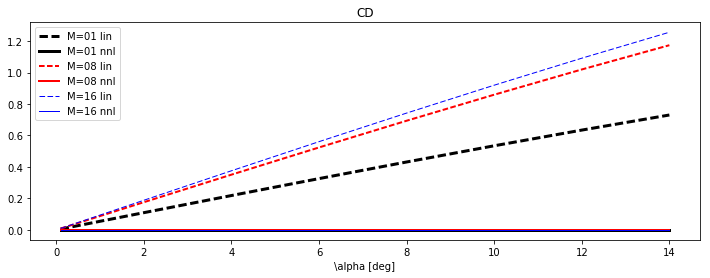

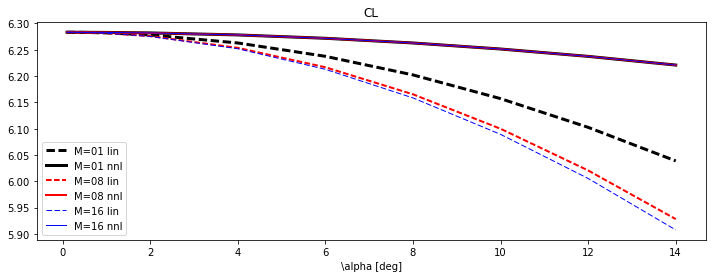

In [46]:
MList=[1,8,16]
DAlphaList=[0.1,0.5,1.,2.,4.,6.,8.,10.,12.,14.] # degs

Nm=len(MList)
Na=len(DAlphaList)

CDlin,CLlin=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDnnl,CLnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

for mm in range(len(MList)):

    # input: reference condition: flat plate at zero angle
    Mw=2
    M=MList[mm]
    alpha=0.*np.pi/180.
    chord=3.
    b=0.5*chord
    Uinf=np.array([20.,0.])
    rho=1.225
    S0=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
    S0.build_flat_plate()
    S0.solve_static_Gamma2d()

    print('Testing steady aerofoil for M=%d...' %M)

    for aa in range(len(DAlphaList)):

        # Perturbation
        dalpha=np.pi/180.*DAlphaList[aa] # angle [rad]
        dUinf=0.0 # velocity [m/s]
        qinf_tot=0.5*rho*(S0.Uabs+dUinf)**2
        print('\talpha==%.2f deg' %DAlphaList[aa])


        ### Linearised solution 

        # Perturb reference state
        ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
        dZeta=ZetaRot-S0.Zeta
        Slin=linuvlm.solver(S0)
        Slin.Zeta=dZeta
        # solve
        Slin.solve_static_Gamma2d()
        # store data
        CDlin[aa,mm],CLlin[aa,mm]=np.sum(Slin.FmatSta,0)/\
                                 (qinf_tot*Slin.S0.chord*(alpha+dalpha))

        ### Reference nonlinear solution
        Sref=uvlm.solver(M,Mw,b,Uinf,alpha+dalpha,rho)
        Sref.build_flat_plate()
        # solve
        Sref.solve_static_Gamma2d()
        # store
        CDnnl[aa,mm],CLnnl[aa,mm]=np.sum(Sref.FmatSta,0)/\
                                    (qinf_tot*Sref.chord*(alpha+dalpha))

clist=['k','r','b','0.6',]
fig1 = plt.figure('Drag coefficient',(12,4))
ax1=fig1.add_subplot(111)
fig2 = plt.figure('Lift coefficient',(12,4))
ax2=fig2.add_subplot(111)

for mm in range(Nm):
    #
    ax1.plot(DAlphaList,CDlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax1.plot(DAlphaList,CDnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])
    #
    ax2.plot(DAlphaList,CLlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax2.plot(DAlphaList,CLnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])

ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'CD')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'CL')
ax2.legend()
plt.show()

The error with respect to the analytical value of the lift coefficient $2\pi$ is shown below:

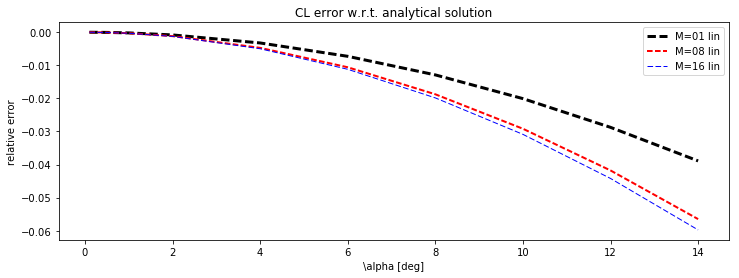

In [47]:
fig1 = plt.figure('Relative error lift coefficient',(12,4))
ax1=fig1.add_subplot(111)
for mm in range(Nm):
    ax1.plot(DAlphaList,CLlin[:,mm]/(2.*np.pi)-1.,clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
ax1.set_xlabel(r'\alpha [deg]')
ax1.set_ylabel(r'relative error')
ax1.set_title(r'CL error w.r.t. analytical solution')
ax1.legend()
ax2.legend()
plt.show()

- The nonlinear solution is consistent across parametrisation with the $CL_\alpha \to 2\pi$ as $\alpha \to 0$. 
- The linear solution converges to the reference on as $\alpha \to 0$
- The $CL_\alpha$ computed through the linear model decreases below the analytical value $2\pi$ as $\alpha$ increases. This is consistent to what predicted by the geometrically-exact model, and may be linked to the fact that also $x$ displacements $\Delta\zeta_x$ are enforced as the aerofoil is rotated.
#### To verify: Why the $CD_\alpha$ does not remain null as $\alpha$ moves away from 0 deg? Is this linked to the fact that, while perturbing the geometry, also $x$ displacements $\Delta\zeta_x$ are enforced? Another possibility is that the force term is not linearised.

### Investigation: rotation without horizontal displacements

To investigate the reason for the $CL_\alpha$ falling with $\alpha$, in the next test case the aerofoil is rotated without imposing horizontal displacements. This makes the case more consistent to the one in analytical theory.

Testing steady aerofoil for M=1...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=8...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg
Testing steady aerofoil for M=16...
	alpha==0.10 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==10.00 deg
	alpha==12.00 deg
	alpha==14.00 deg


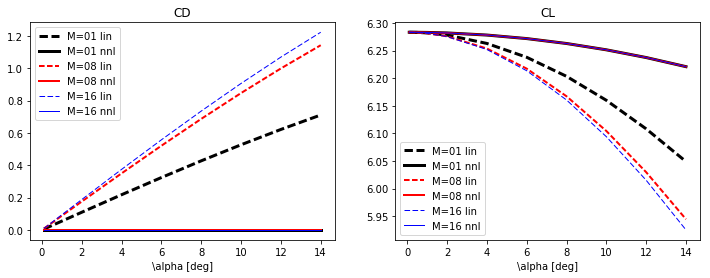

In [48]:
for mm in range(len(MList)):

    # input: reference condition: flat plate at zero angle
    Mw=2
    M=MList[mm]
    alpha=0.*np.pi/180.
    chord=3.
    b=0.5*chord
    Uinf=np.array([20.,0.])
    rho=1.225
    S0=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
    S0.build_flat_plate()
    S0.solve_static_Gamma2d()

    print('Testing steady aerofoil for M=%d...' %M)

    for aa in range(len(DAlphaList)):

        # Perturbation
        dalpha=np.pi/180.*DAlphaList[aa] # angle [rad]
        dUinf=0.0 # velocity [m/s]
        qinf_tot=0.5*rho*(S0.Uabs+dUinf)**2
        print('\talpha==%.2f deg' %DAlphaList[aa])


        ### Linearised solution 

        # Perturb reference state
        ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
        dZeta=ZetaRot-S0.Zeta
        Slin=linuvlm.solver(S0)
        Slin.Zeta[:,1]=dZeta[:,1]
        # solve
        Slin.solve_static_Gamma2d()
        # store data
        CDlin[aa,mm],CLlin[aa,mm]=np.sum(Slin.FmatSta,0)/\
                                 (qinf_tot*Slin.S0.chord*(alpha+dalpha))

        ### Reference nonlinear solution
        Sref=uvlm.solver(M,Mw,b,Uinf,alpha+dalpha,rho)
        Sref.build_flat_plate()
        # solve
        Sref.solve_static_Gamma2d()
        # store
        CDnnl[aa,mm],CLnnl[aa,mm]=np.sum(Sref.FmatSta,0)/\
                                    (qinf_tot*Sref.chord*(alpha+dalpha))


clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic coefficients',(12,4))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for mm in range(Nm):
    #
    ax1.plot(DAlphaList,CDlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax1.plot(DAlphaList,CDnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])
    #
    ax2.plot(DAlphaList,CLlin[:,mm],clist[mm],lw=Nm-mm,ls='--',
                                          label=r'M=%.2d lin'%MList[mm])
    ax2.plot(DAlphaList,CLnnl[:,mm],clist[mm],lw=Nm-mm,
                                          label=r'M=%.2d nnl'%MList[mm])

ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'CD')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'CL')
ax2.legend()
plt.show()

The trends are almost unchanged with respect to the "exact rotation" case, meaning the horizontal displacements are not having an impact.

## Cambered plate: nonlinear vs. linearised

In this test a model of a camber plate is considered. Two linearisations of this model, about 0 deg and 10 deg are considered. The aerodynamic forced computed through these two models are compared to those predicted by the geometrically-exact solution over a range of angles of attack.

As before, rotation is imposed on the linear model enforcing both $x$ and $y$ displacements.

Testing steady aerofoil for M=20...
	alpha==0.00 deg
	alpha==0.10 deg


/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:76: RuntimeWarning: divide by zero encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:86: RuntimeWarning: divide by zero encountered in true_divide


	alpha==0.20 deg
	alpha==0.30 deg
	alpha==0.50 deg
	alpha==1.00 deg
	alpha==2.00 deg
	alpha==4.00 deg
	alpha==6.00 deg
	alpha==8.00 deg
	alpha==9.50 deg
	alpha==9.70 deg
	alpha==9.80 deg
	alpha==9.90 deg
	alpha==10.00 deg
	alpha==10.10 deg
	alpha==10.20 deg
	alpha==10.30 deg
	alpha==10.50 deg
	alpha==12.00 deg
	alpha==14.00 deg
	alpha==16.00 deg
	alpha==18.00 deg


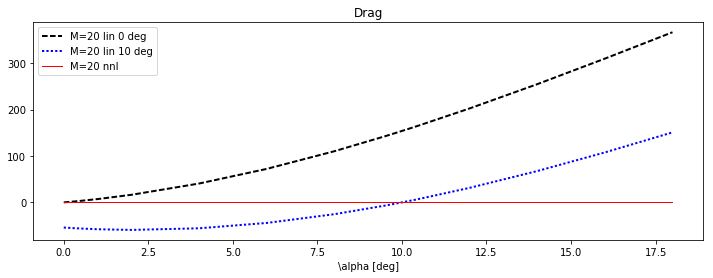

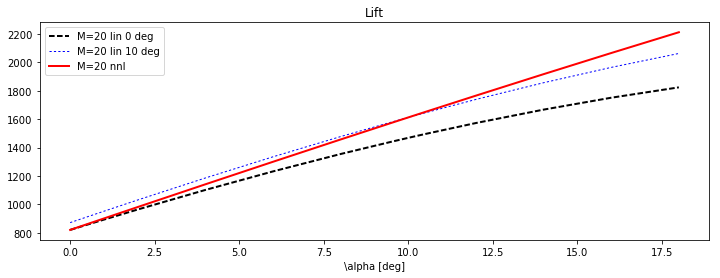

In [49]:
DAlphaList=[0.0,0.1,0.2,0.3,0.5,1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,12.,14.,16.,18.] # degs

MList=[20]
Nm,mm=1,0
Na=len(DAlphaList)

CDlin01,CLlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDlin02,CLlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
CDnnl,CLnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

Llin01,Dlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Llin02,Dlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
Lnnl,Dnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

# input:
Mw=2
M=20
chord=3.
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225

# reference condition 1: aerofoil at 0 deg angle
alpha01=0.*np.pi/180.
S01=uvlm.solver(M,Mw,b,Uinf,alpha01,rho=1.225)
S01.build_camber_plate(Mcamb=10,Pcamb=4)
S01.solve_static_Gamma2d()
Ftot0=np.sum(S01.FmatSta,0)

# reference condition 2: aerofoil at 10 deg angle
alpha02=10.*np.pi/180.
S02=uvlm.solver(M,Mw,b,Uinf,alpha02,rho=1.225)
S02.build_camber_plate(Mcamb=10,Pcamb=4)
S02.solve_static_Gamma2d()


print('Testing steady aerofoil for M=%d...' %M)

for aa in range(len(DAlphaList)):

    # Perturbation
    alpha_tot=np.pi/180.*DAlphaList[aa]
    dUinf=0.0 # velocity [m/s]
    qinf_tot=0.5*rho*(S01.Uabs+dUinf)**2
    print('\talpha==%.2f deg' %DAlphaList[aa])


    ### Linearised solution 01:
    # Perturb reference state
    dalpha01=alpha_tot-alpha01 # angle [rad]
    ZetaRot=geo.rotate_aerofoil(S01.Zeta,dalpha01)
    dZeta=ZetaRot-S01.Zeta
    Slin01=linuvlm.solver(S01)
    Slin01.Zeta=dZeta
    # solve
    Slin01.solve_static_Gamma2d()
    # store data
    Dlin01[aa,mm],Llin01[aa,mm]=np.sum(Slin01.FmatSta,0)
    dFtot01=np.sum(Slin01.FmatSta,0)-Ftot0
    CDlin01[aa,mm],CLlin01[aa,mm]=dFtot01/\
                                (qinf_tot*Slin01.S0.chord*alpha_tot)


    ### Linearised solution 02:
    # Perturb reference state
    dalpha02=alpha_tot-alpha02 # angle [rad]
    ZetaRot=geo.rotate_aerofoil(S02.Zeta,dalpha02)
    dZeta=ZetaRot-S02.Zeta
    Slin02=linuvlm.solver(S02)
    Slin02.Zeta=dZeta
    # solve
    Slin02.solve_static_Gamma2d()
    # store data
    Dlin02[aa,mm],Llin02[aa,mm]=np.sum(Slin02.FmatSta,0)
    dFtot02=np.sum(Slin02.FmatSta,0)-Ftot0
    CDlin02[aa,mm],CLlin02[aa,mm]=dFtot02/\
                                (qinf_tot*Slin02.S0.chord*alpha_tot)


    ### Reference nonlinear solution
    Sref=uvlm.solver(M,Mw,b,Uinf,alpha_tot,rho)
    Sref.build_camber_plate(Mcamb=10,Pcamb=4)
    # solve
    Sref.solve_static_Gamma2d()
    # store
    Dnnl[aa,mm],Lnnl[aa,mm]=np.sum(Sref.FmatSta,0)
    CDnnl[aa,mm],CLnnl[aa,mm]=np.sum(Sref.FmatSta,0)/\
                                     (qinf_tot*Sref.chord*alpha_tot)



clist=['k','r','b','0.6',]

### Aerodynamic forces
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,Dlin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Dlin02[:,mm],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
ax1.plot(DAlphaList,Dnnl[:,mm],'r',lw=Nm-mm,
                                      label=r'M=%.2d nnl'%MList[mm])
#
ax2.plot(DAlphaList,Llin01[:,mm],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,Llin02[:,mm],'b',lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
ax2.plot(DAlphaList,Lnnl[:,mm],'r',lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])

ax1.set_xlabel(r'\alpha [deg]')
ax1.set_title(r'Drag')
ax1.legend()
ax2.set_xlabel(r'\alpha [deg]')
ax2.set_title(r'Lift')
ax2.legend()
plt.show()

As expected, the force predicted through the linear models is closer to the reference solution as $\alpha\to\alpha_0$ (where $\alpha_0=0,10$ deg are the angle about which they have been linearised. 
#### As for the flat plate, the drag does not remain zero across the range of angles of attack. This needs to be understood.

A plot of the relative error in computing the lift is shown below:

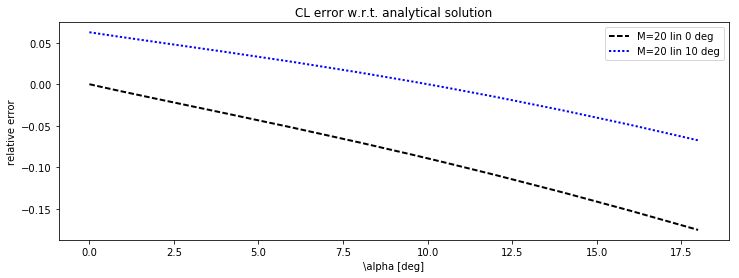

In [50]:
fig1 = plt.figure('Relative error lift coefficient',(12,4))
ax1=fig1.add_subplot(111)
ax1.plot(DAlphaList,Llin01[:,mm]/Lnnl[:,mm]-1.,'k',lw=2,ls='--',
                                      label=r'M=%.2d lin 0 deg'%MList[mm])
ax1.plot(DAlphaList,Llin02[:,mm]/Lnnl[:,mm]-1.,'b',lw=2,ls=':',
                                     label=r'M=%.2d lin 10 deg'%MList[mm])
ax1.set_xlabel(r'\alpha [deg]')
ax1.set_ylabel(r'relative error')
ax1.set_title(r'CL error w.r.t. analytical solution')
ax1.legend()
ax2.legend()
plt.show()

In [51]:
ax2.plot(DAlphaList,Llin01[:,mm],clist[mm],lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%MList[mm])
ax2.plot(DAlphaList,Llin02[:,mm],clist[mm],lw=Nm-mm,ls=':',
                               label=r'M=%.2d lin 10 deg'%MList[mm])
ax2.plot(DAlphaList,Lnnl[:,mm],clist[mm],lw=2,
                                      label=r'M=%.2d nnl'%MList[mm])

A plot of the aerofoil at 0 and 10 deg is shown below:

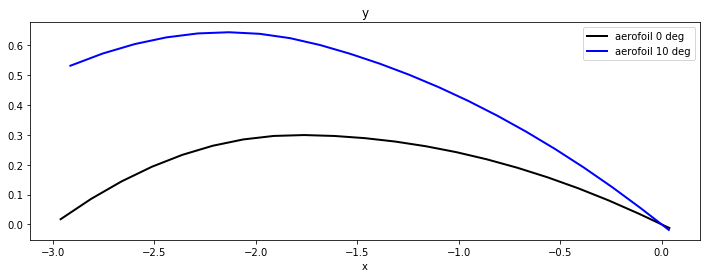

In [52]:
fig1 = plt.figure('Aerofoil',(12,4))
ax1=fig1.add_subplot(111)
ax1.plot(S01.Zeta[:,0],S01.Zeta[:,1],'k',lw=2,
                                label=r'aerofoil 0 deg')
ax1.plot(S02.Zeta[:,0],S02.Zeta[:,1],'b',lw=2,
                               label=r'aerofoil 10 deg')
ax1.set_xlabel(r'x')
ax1.set_title(r'y')
ax1.legend()
plt.show()

### Further tests:
- investigate effect of increments of velocities $\Delta\nu$ (free stream) and $\Delta\zeta'$ (aerofoil motion).
- Implement dynamic solution with linear state equations and exact output (force).
- Understand $CD_\alpha \neq 0$ after also the output (force) equations are linearised.

## Cambered aerofoil - gust speed increment

The same cambered aerofoil, at geometrical angles of 0 and 10 deg, defined above is now used to test the linearisation with respect to increments of gust velocity. To this aim, lift and drag are computed for a range of effective angles of attack, $\alpha_{eff}$. The gust speed, $w$ is used to tilt the original flow field so as to achieve $\alpha_{eff}$. The magnitude of the aerodynamic force is maintained constant. 

If $\alpha$ is the flow angle, and $\alpha_0=0, 10$ deg are the geometrical angles of the aerofoil about the horizontal line, this is achieved by setting:
$$
\alpha=\alpha_{eff}+\alpha_0
$$
and solving:
$$
u_z+w_z= (u_x+w_x) \tan\alpha \\
(wx+ux)^2 + (w_z+u_z)^2=U_\infty
$$

Testing steady aerofoil for M=20...
	Alpha effective=0.00 deg
	Alpha effective=0.10 deg


/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:96: RuntimeWarning: divide by zero encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:106: RuntimeWarning: divide by zero encountered in true_divide


	Alpha effective=0.20 deg
	Alpha effective=0.30 deg
	Alpha effective=0.50 deg
	Alpha effective=1.00 deg
	Alpha effective=2.00 deg
	Alpha effective=4.00 deg
	Alpha effective=6.00 deg
	Alpha effective=8.00 deg
	Alpha effective=9.50 deg
	Alpha effective=9.70 deg
	Alpha effective=9.80 deg
	Alpha effective=9.90 deg
	Alpha effective=10.00 deg
	Alpha effective=10.10 deg
	Alpha effective=10.20 deg
	Alpha effective=10.30 deg
	Alpha effective=10.50 deg
	Alpha effective=12.00 deg
	Alpha effective=14.00 deg
	Alpha effective=16.00 deg
	Alpha effective=18.00 deg


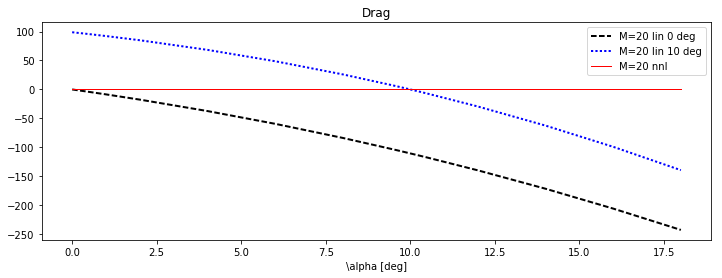

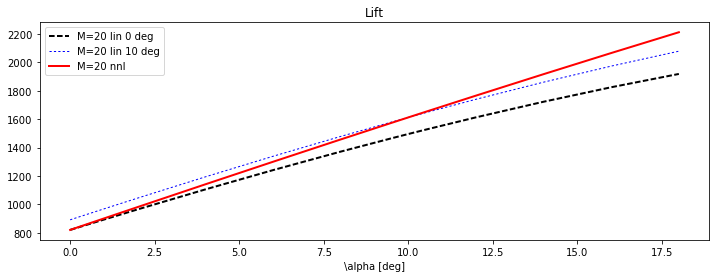

In [53]:
		DAlphaList=[0.0,0.1,0.2,0.3,0.5,1.,2.,4.,6.,8.,
		            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,12.,14.,16.,18.] # degs
		#DAlphaList=[5.0]

		MList=[20]
		Nm,mm=1,0
		Na=len(DAlphaList)

		CDlin01,CLlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
		CDlin02,CLlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
		CDnnl,CLnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

		Llin01,Dlin01=np.zeros((Na,Nm)),np.zeros((Na,Nm))
		Llin02,Dlin02=np.zeros((Na,Nm)),np.zeros((Na,Nm))
		Lnnl,Dnnl=np.zeros((Na,Nm)),np.zeros((Na,Nm))

		# input:
		Mw=2
		M=MList[mm]
		chord=3.
		b=0.5*chord
		Uinf=np.array([20.,0.])
		rho=1.225

		# reference condition 1: aerofoil at 0 deg angle
		alpha01=0.*np.pi/180.
		S01=uvlm.solver(M,Mw,b,Uinf,alpha01,rho=1.225)
		S01.build_camber_plate(Mcamb=10,Pcamb=4)
		S01.solve_static_Gamma2d()
		Ftot0=np.sum(S01.FmatSta,0)

		# reference condition 2: aerofoil at 10 deg angle
		alpha02=10.*np.pi/180.
		S02=uvlm.solver(M,Mw,b,Uinf,alpha02,rho=1.225)
		S02.build_camber_plate(Mcamb=10,Pcamb=4)
		S02.solve_static_Gamma2d()


		print('Testing steady aerofoil for M=%d...' %M)


		def get_wvec(aeff,a0,ux,uz):

			# get free stream angle
			a=aeff-a0
			tga=np.tan(a)

			### build residual
			def Fres(x):
				'''@warning: uses function variables!'''
				wx,wz=x
				F=np.zeros((2,))
				F[0]=tga*(ux+wx)-(uz+wz)
				F[1]=wx**2+2.*wx*ux+wz**2+2.*uz*wz
				return F

			# solve nnl equations
			x0=np.zeros((2,))
			wvec=scopt.newton_krylov(Fres,x0)

			asol=np.tan((uz+wvec[1])/(ux+wvec[0]))
			assert (asol-(aeff-a0))**2<1e-3, 'Solution not found!'

			return wvec


		for aa in range(len(DAlphaList)):

			# Perturbation
			alpha_eff=np.pi/180.*DAlphaList[aa]
			qinf_tot=0.5*rho*(S01.Uabs)**2
			print('\tAlpha effective=%.2f deg' %DAlphaList[aa])

			### Linearised solution 01:
			# Perturb reference state
			Slin01=linuvlm.solver(S01)
			wvec=get_wvec(alpha_eff,alpha01,Uinf[0],Uinf[1])
			Slin01.Wzeta[:,:]=wvec
			# solve
			Slin01.solve_static_Gamma2d()
			# store data
			Dlin01[aa,mm],Llin01[aa,mm]=np.sum(Slin01.FmatSta,0)
			dFtot01=np.sum(Slin01.FmatSta,0)-Ftot0
			CDlin01[aa,mm],CLlin01[aa,mm]=dFtot01/\
			                                (qinf_tot*Slin01.S0.chord*alpha_eff)

			### Linearised solution 02:
			# Perturb reference state
			Slin02=linuvlm.solver(S02)
			wvec=get_wvec(alpha_eff,alpha02,Uinf[0],Uinf[1])
			Slin02.Wzeta[:,:]=wvec
			# solve
			Slin02.solve_static_Gamma2d()
			# store data
			Dlin02[aa,mm],Llin02[aa,mm]=np.sum(Slin02.FmatSta,0)
			dFtot02=np.sum(Slin02.FmatSta,0)-Ftot0
			CDlin02[aa,mm],CLlin02[aa,mm]=dFtot02/\
			                                (qinf_tot*Slin02.S0.chord*alpha_eff)


			### Reference nonlinear solution
			Sref=uvlm.solver(M,Mw,b,Uinf,alpha_eff,rho)
			Sref.build_camber_plate(Mcamb=10,Pcamb=4)
			# solve
			Sref.solve_static_Gamma2d()
			# store
			Dnnl[aa,mm],Lnnl[aa,mm]=np.sum(Sref.FmatSta,0)
			CDnnl[aa,mm],CLnnl[aa,mm]=np.sum(Sref.FmatSta,0)/\
			                                     (qinf_tot*Sref.chord*alpha_eff)


		clist=['k','r','b','0.6',]
		### Aerodynamic forces
		fig1 = plt.figure('Drag',(12,4))
		fig2 = plt.figure('Lift',(12,4))
		ax1=fig1.add_subplot(111)
		ax2=fig2.add_subplot(111)

		ax1.plot(DAlphaList,Dlin01[:,mm],'k',lw=2,ls='--',
		                                label=r'M=%.2d lin 0 deg'%MList[mm])
		ax1.plot(DAlphaList,Dlin02[:,mm],'b',lw=2,ls=':',
		                               label=r'M=%.2d lin 10 deg'%MList[mm])
		ax1.plot(DAlphaList,Dnnl[:,mm],'r',lw=Nm-mm,
		                                      label=r'M=%.2d nnl'%MList[mm])
		#
		ax2.plot(DAlphaList,Llin01[:,mm],'k',lw=2,ls='--',
		                                label=r'M=%.2d lin 0 deg'%MList[mm])
		ax2.plot(DAlphaList,Llin02[:,mm],'b',lw=Nm-mm,ls=':',
		                               label=r'M=%.2d lin 10 deg'%MList[mm])
		ax2.plot(DAlphaList,Lnnl[:,mm],'r',lw=2,
		                                      label=r'M=%.2d nnl'%MList[mm])

		ax1.set_xlabel(r'\alpha [deg]')
		ax1.set_title(r'Drag')
		ax1.legend()
		ax2.set_xlabel(r'\alpha [deg]')
		ax2.set_title(r'Lift')
		ax2.legend()
		plt.show()

- The lift force as the same trend as per rotation
- Drag shows now a decreasing trend with increase of effective angle of attack. It is, however, not realistic.

Using the same criterion, similar results are obtained enforcing the velocity of the aerofoil nodes.